In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram


def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch

import matplotlib.dates as mdates
import datetime


def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

def plot_spectrogram(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.Spectrogram(n_fft=2**6, hop_length=1)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto', cmap='gist_rainbow')
    

def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id].copy()
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)

def plot_aic_pick(event, ax):
    times = get_times(event=event)
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-0.5, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

def plot_p(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    
    # find max/min peak
    start = 180
    end = 199
    if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
        ploc_t = times[np.argmax(tr.data[start:end]) + start]
        ploc_y = np.max(tr.data[start:end])
    else:
        ploc_t = times[np.argmin(tr.data[start:end]) + start]
        ploc_y = np.min(tr.data[start:end])
    
    # ax.plot(times, tr.data, color='cyan', alpha=0.5, label='what is this?')
    print(ploc_t, ploc_y)
    print(tr.data.shape)
    ax.plot(ploc_t, ploc_y, marker='*', linestyle='', color='red', label='p-arrival pick')

def plot_aic(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

def plot_aic_diff(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

def plot_event(event_id, day_number, df):
    
    e = get_event(event_id=event_id, day_number=day_number, df=df)
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

    plot_50hz_highpass(event=e, ax=ax[0])
    
    plot_aic_pick(event=e,  ax=ax[0])

    plot_p(event=e, ax=ax[0])
    
    plot_aic(event=e, ax=ax[1])
    
    ax2 = ax[1].twinx()
    
    plot_aic_diff(event=e, ax=ax2)
    
    plot_spectrogram(event=e, ax=ax[2])
    
    ax[0].set_ylabel('Pressure (Pa)', fontsize=15)
    ax[0].legend(fontsize=15, loc='upper right')
    ax[1].set_ylabel('AIC', fontsize=15, color='magenta')
    ax2.set_ylabel('diff(AIC)', fontsize=15, color='cyan')
    ax[2].set_ylabel('Hz', fontsize=15)
    ax[2].set_yticks(np.arange(0, 32, 5))
    ax[2].set_yticklabels(np.arange(0, 32, 5) * 500 / 32)
    fig.tight_layout()

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime', 'origin_time']

df141 = import_catalog(file='141precision.csv')

df141 = df141[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
df141['id']

16        16
20        20
25        25
26        26
32        32
        ... 
2236    2236
2237    2237
2238    2238
2239    2239
2240    2240
Name: id, Length: 1931, dtype: int64

In [4]:
vels = []
depths = []
ptimes = []

In [5]:
# %matplotlib widget
def plot_event_for_p_pick(event_id, ptime):
    fig, ax = plt.subplots(figsize=(15, 5))
    e = get_event(event_id=event_id, day_number=141, df=df141)
    plot_50hz_highpass(event=e, ax=ax)
    plot_aic_pick(event=e, ax=ax)
    ax.arrow(x=ptime*1e3, y=0.75, dx=0, dy=-0.6, color='red', head_width=1, head_length=0.05)
    print('relative depth:', e.relative_depth)
    print('origin time:', df141.origin_time[event_id])
    vel = e.relative_depth/(obspy.UTCDateTime(df141.origin_time[event_id]) - ((e.starttime - 0.2) + ptime))
    print('p velocity:', vel)
    vels.append(vel)
    depths.append(e.depth)
    ptimes.append(0.2 - ptime)

relative depth: 22.75
origin time: 2019-05-21T07:40:53.562500Z
p velocity: 1978.2608695652175


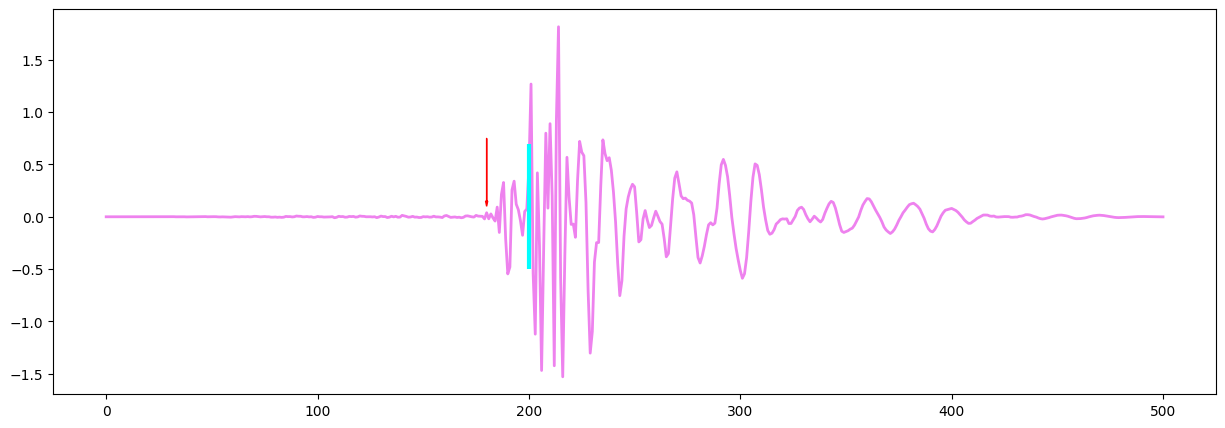

In [6]:
plot_event_for_p_pick(event_id=127, ptime=0.180)

relative depth: 15.75
origin time: 2019-05-21T07:44:28.720500Z
p velocity: 3500.0000000000005


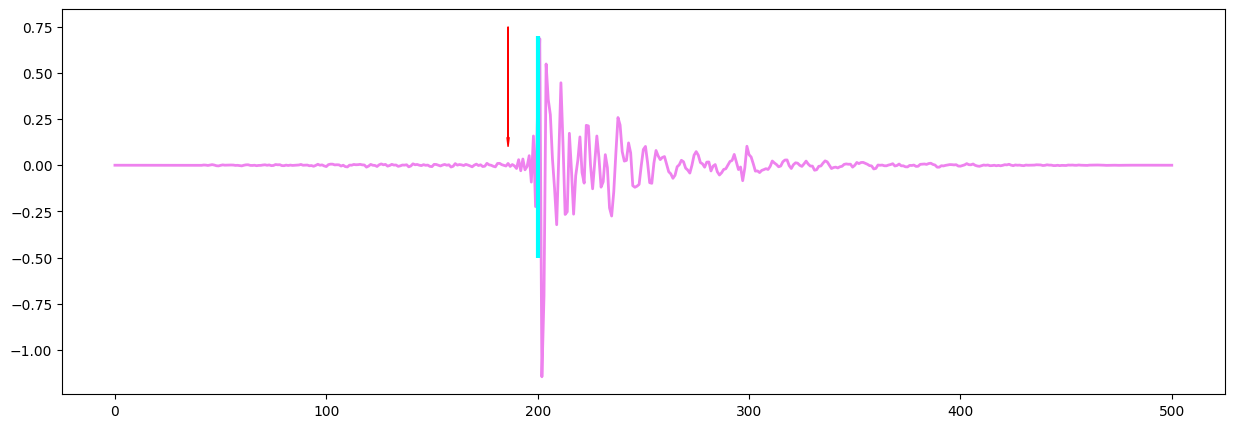

In [7]:
plot_event_for_p_pick(event_id=251, ptime=0.186)

relative depth: 34.125
origin time: 2019-05-21T07:49:27.937500Z
p velocity: -4014.705882352941


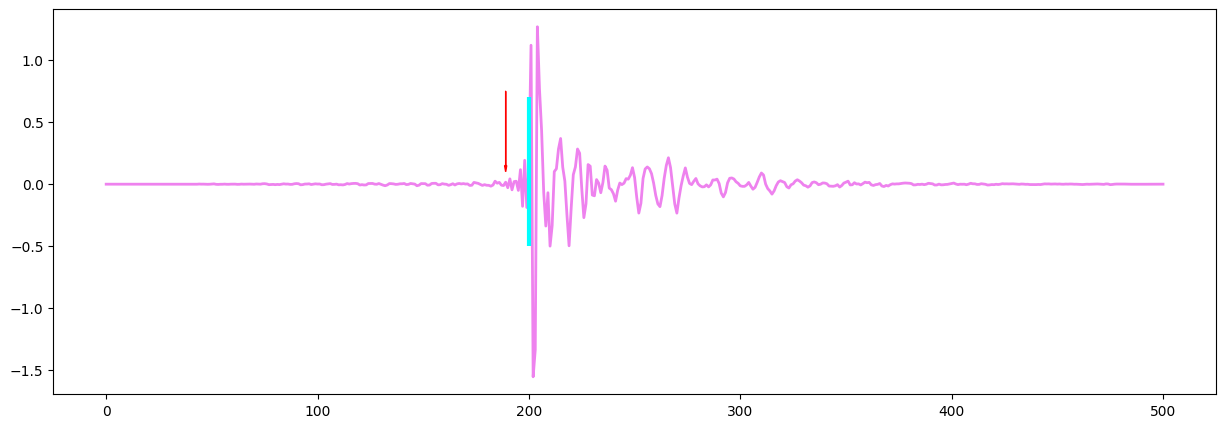

In [8]:
plot_event_for_p_pick(event_id=376, ptime=0.189)

relative depth: 35.0
origin time: 2019-05-21T07:51:01.726000Z
p velocity: -2333.3333333333335


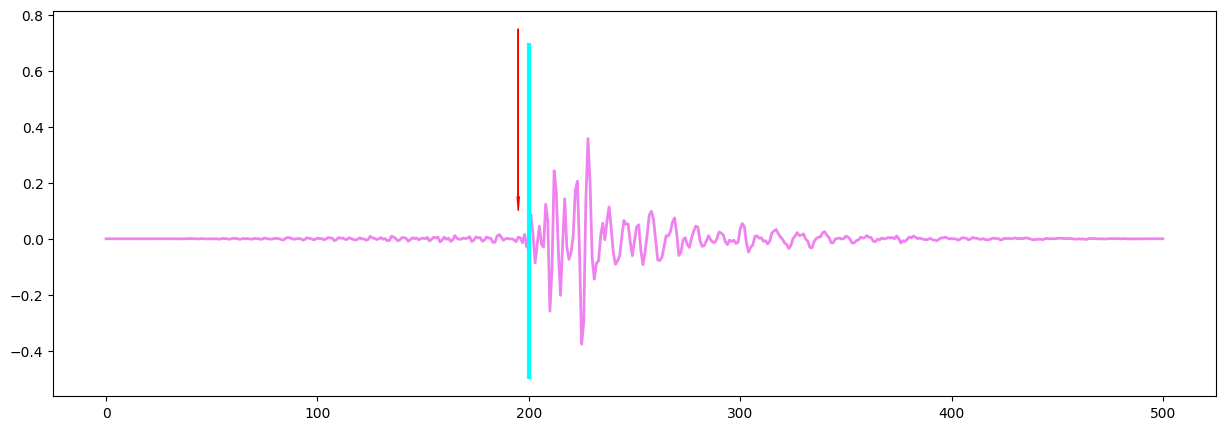

In [9]:
plot_event_for_p_pick(event_id=500, ptime=0.195)

relative depth: 47.25
origin time: 2019-05-21T07:53:15.411000Z
p velocity: -2779.411764705882


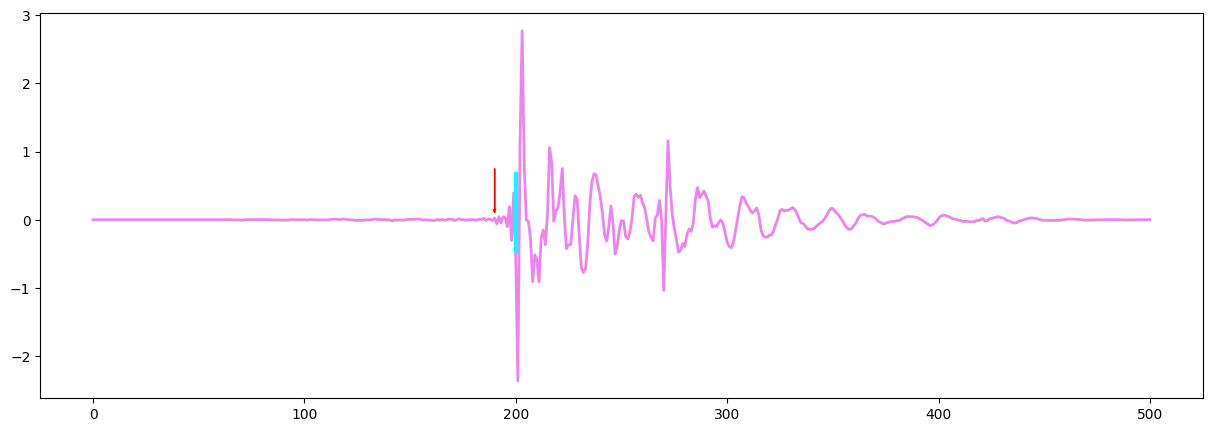

In [10]:
plot_event_for_p_pick(event_id=625, ptime=0.190)

relative depth: 12.25
origin time: 2019-05-21T08:02:31.351000Z
p velocity: 2041.6666666666665


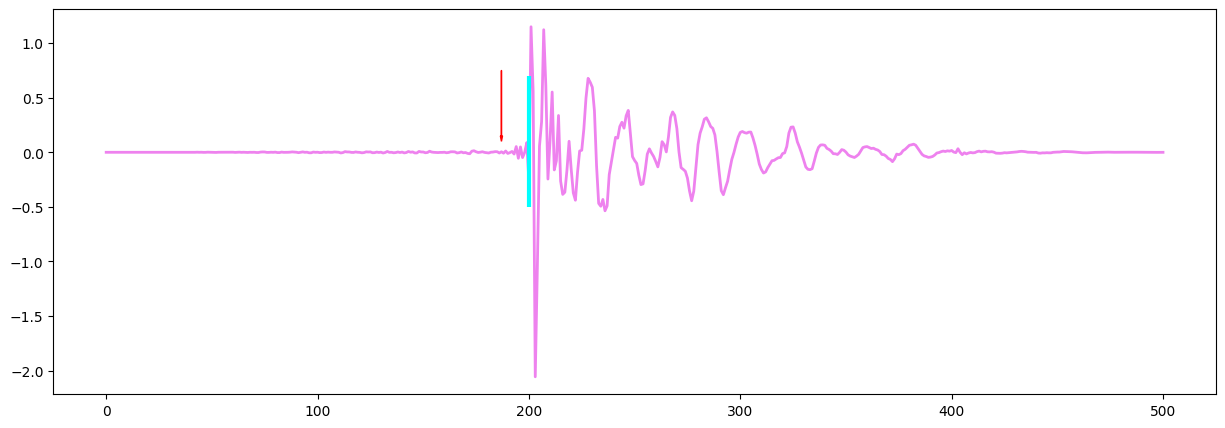

In [11]:
plot_event_for_p_pick(event_id=750, ptime=0.187)

relative depth: 25.375
origin time: 2019-05-21T08:06:13.634500Z
p velocity: -4613.636363636364


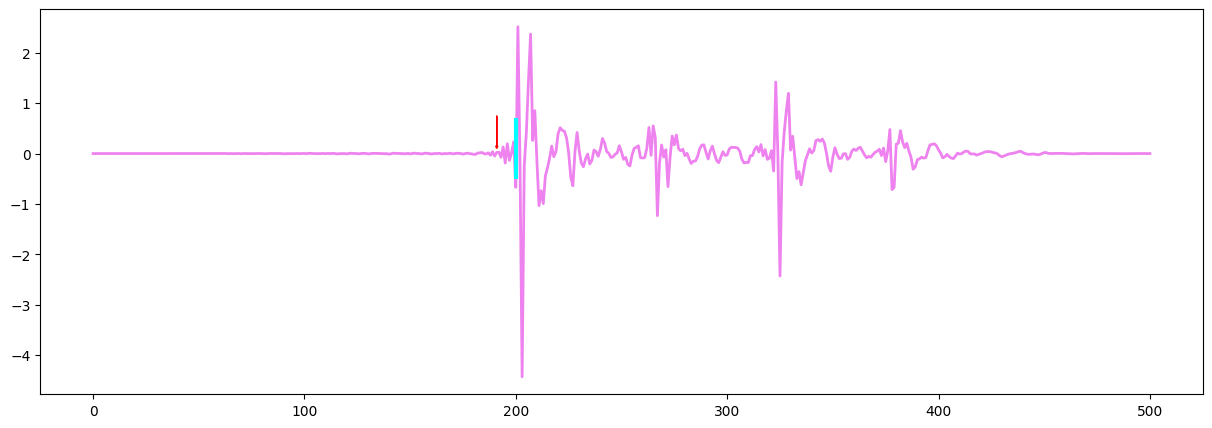

In [12]:
plot_event_for_p_pick(event_id=876, ptime=0.191)

/Users/mnky9800n/repos/boreholeCrack/event_pipeline.py:202: RuntimeWarning: invalid value encountered in sqrt
  self.radius =  np.sqrt(vrock**2 * dt**2 - dz**2)


relative depth: 35.875
origin time: 2019-05-21T08:09:10.748500Z
p velocity: -4783.333333333334


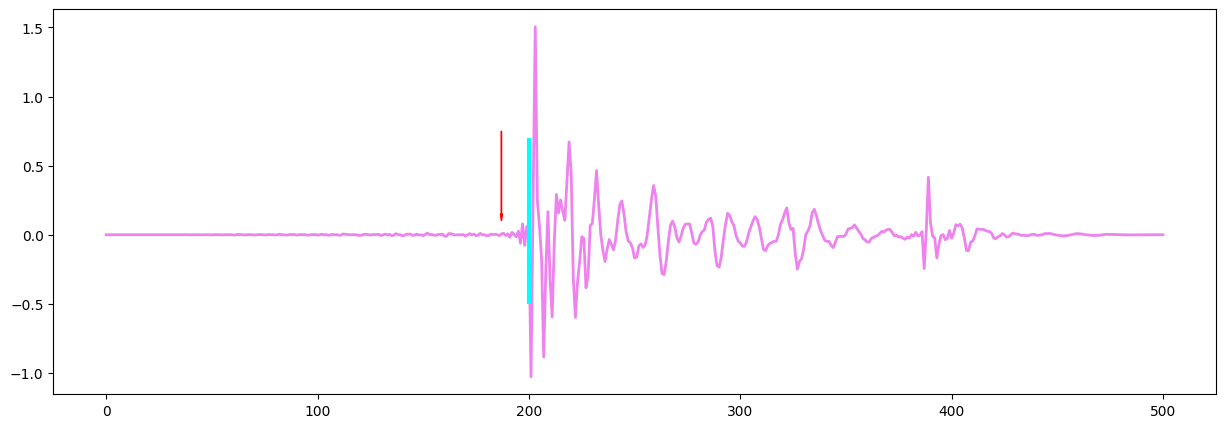

In [13]:
plot_event_for_p_pick(event_id=1002, ptime=0.187)

relative depth: 53.375
origin time: 2019-05-21T08:14:35.139000Z
p velocity: -2541.6666666666665


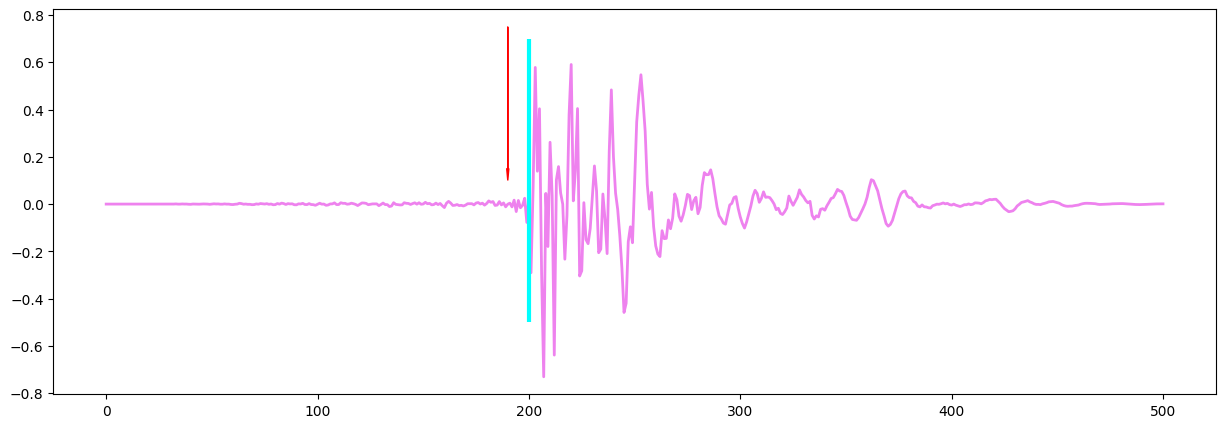

In [14]:
plot_event_for_p_pick(event_id=1125, ptime=0.190)

relative depth: 68.25
origin time: 2019-05-21T08:18:20.189000Z
p velocity: -2527.777777777778


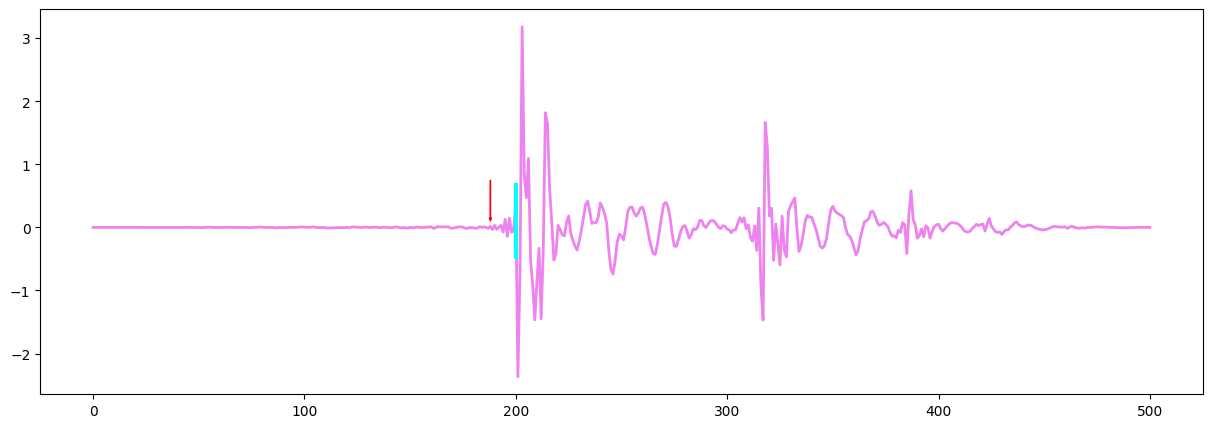

In [15]:
plot_event_for_p_pick(event_id=1252, ptime=0.188)

relative depth: 18.375
origin time: 2019-05-21T08:24:40.698000Z
p velocity: -6125.0


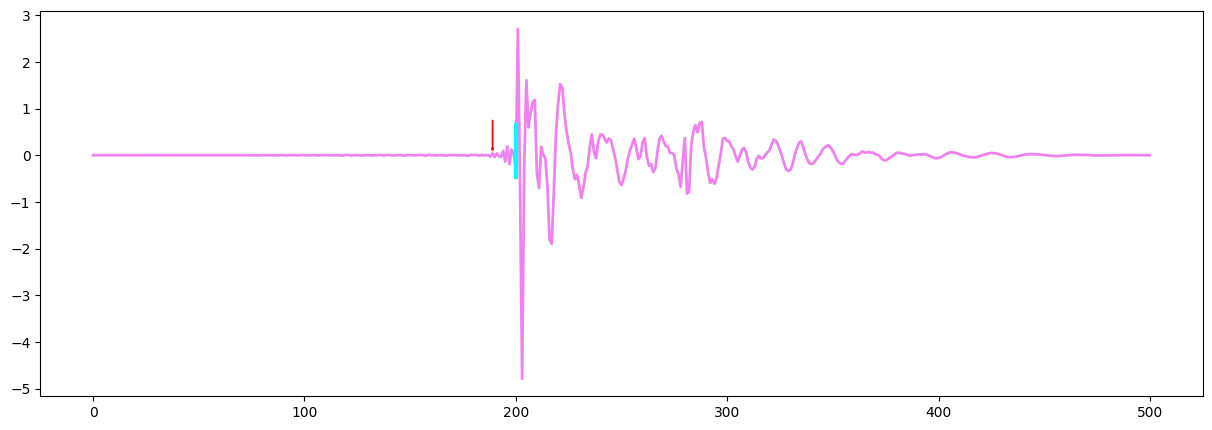

In [16]:
plot_event_for_p_pick(event_id=1505, ptime=0.189)

relative depth: 31.5
origin time: 2019-05-21T08:27:30.156000Z
p velocity: -3500.0000000000005


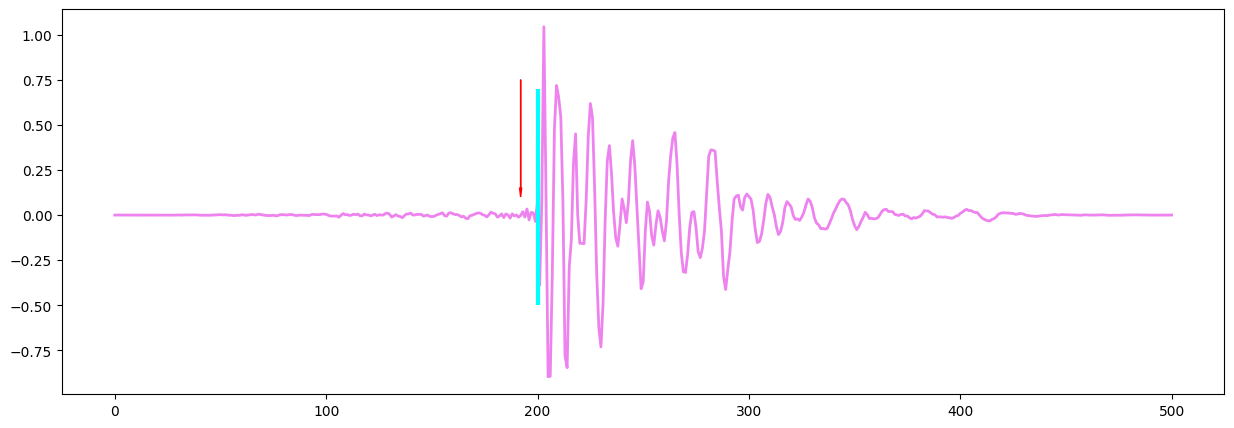

In [17]:
plot_event_for_p_pick(event_id=1676, ptime=0.192)

relative depth: 35.0
origin time: 2019-05-21T08:28:13.606000Z
p velocity: -2333.3333333333335


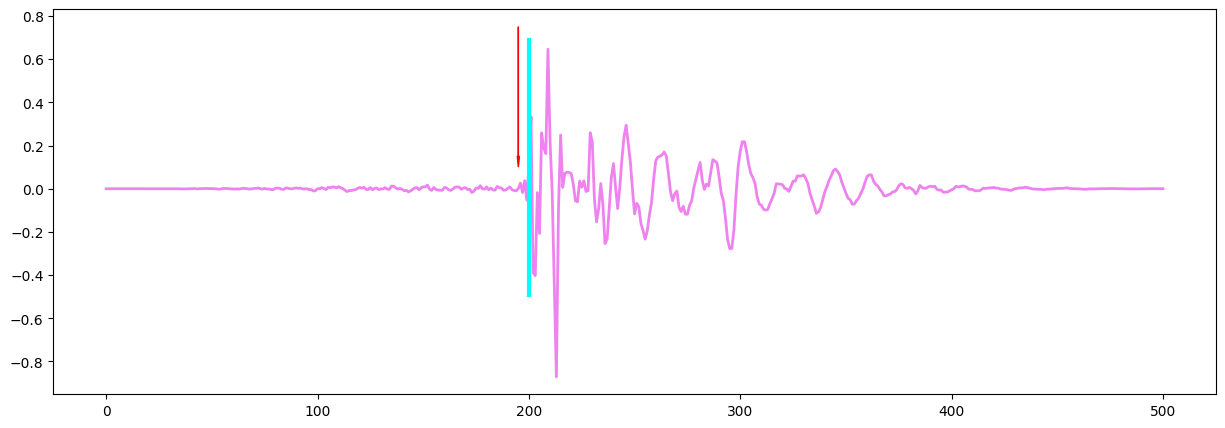

In [18]:
plot_event_for_p_pick(event_id=1750, ptime=0.195)

relative depth: 49.0
origin time: 2019-05-21T08:32:10.771500Z
p velocity: -2177.777777777778


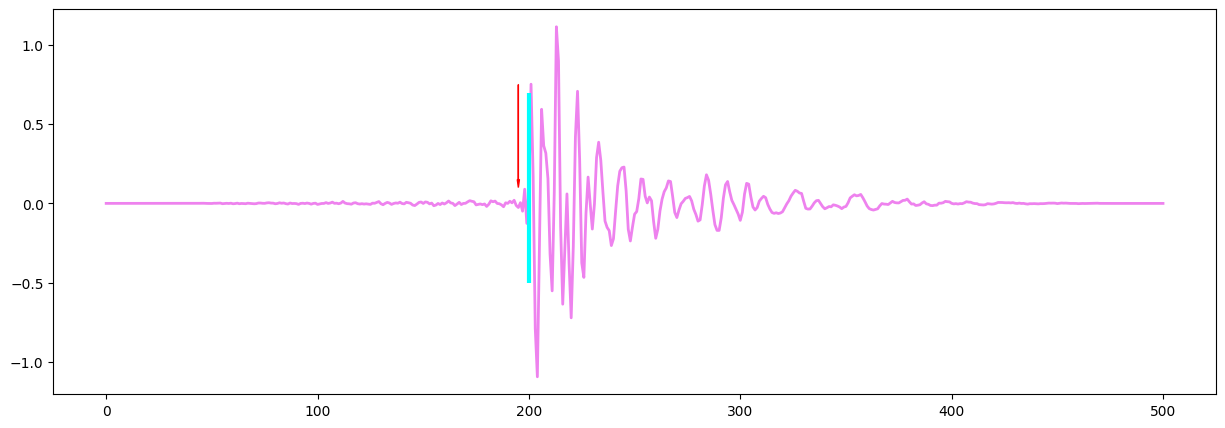

In [19]:
plot_event_for_p_pick(event_id=1875, ptime=0.195)

relative depth: 68.25
origin time: 2019-05-21T08:35:33.079000Z
p velocity: -2625.0


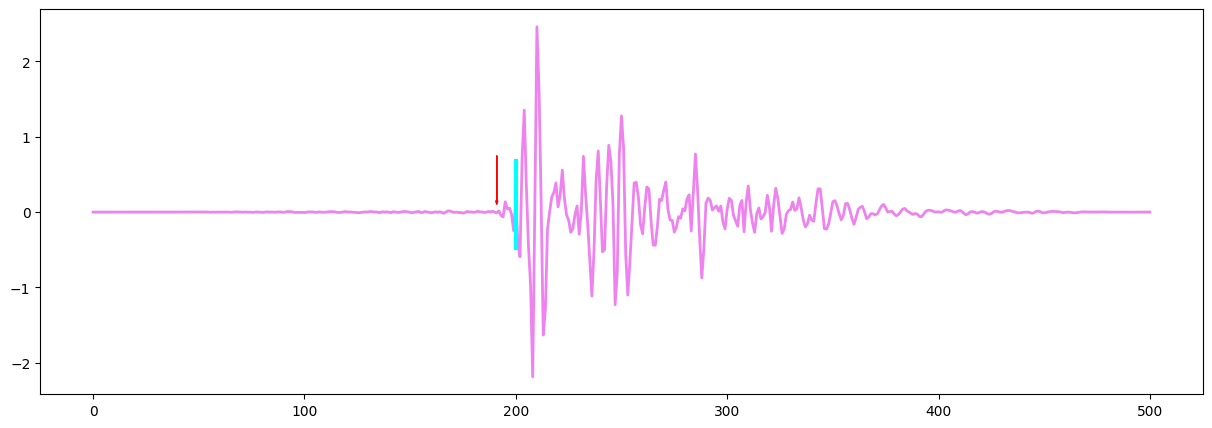

In [20]:
plot_event_for_p_pick(event_id=2000, ptime=0.191)

relative depth: 66.5
origin time: 2019-05-21T08:36:44.594000Z
p velocity: -2375.0


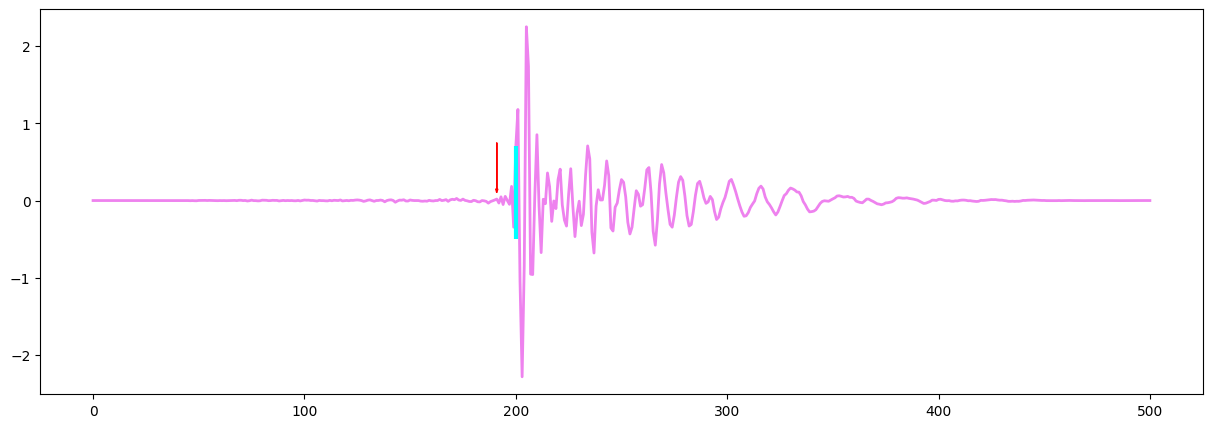

In [21]:
plot_event_for_p_pick(event_id=2128, ptime=0.191)

relative depth: 70.875
origin time: 2019-05-21T08:37:25.536500Z
p velocity: -2486.842105263158


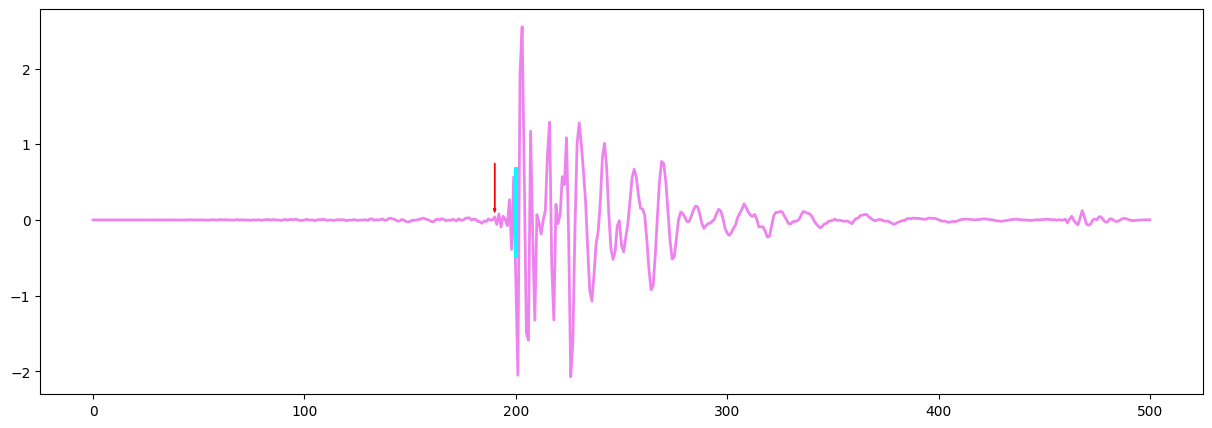

In [22]:
plot_event_for_p_pick(event_id=2200, ptime=0.190)

In [23]:
np.abs(vels).mean()

3102.161522024262

In [24]:
np.abs(ptimes).mean()

0.010235294117647068

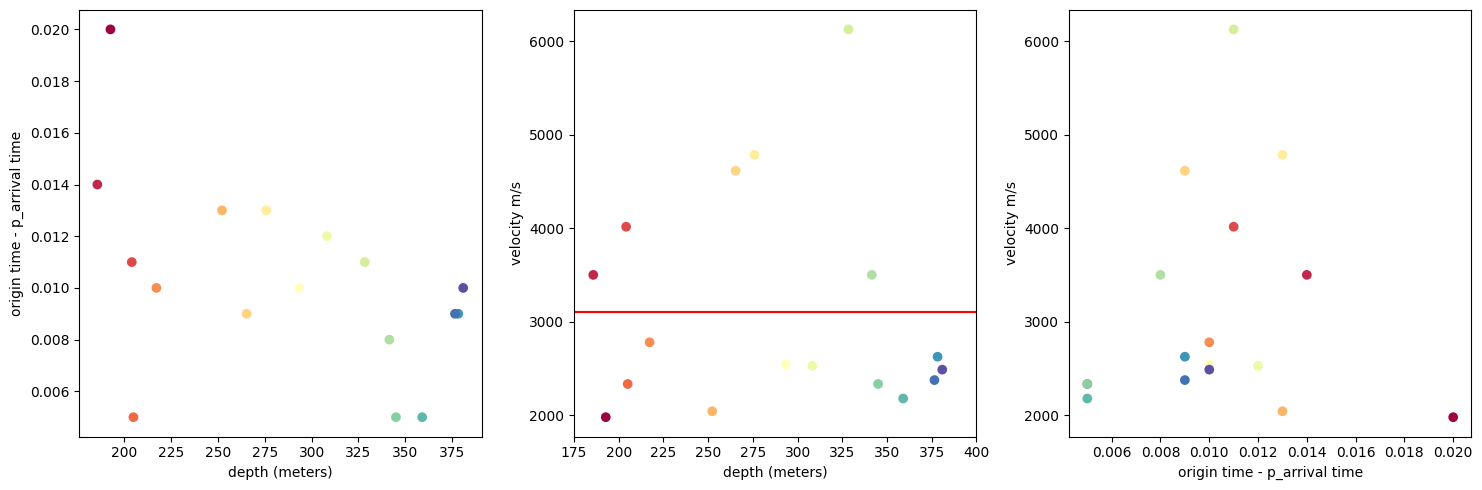

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

colors = np.linspace(0, 1, len(depths))

ax[0].scatter(depths, ptimes, c=plt.cm.Spectral(colors))
ax[0].set_xlabel('depth (meters)')
ax[0].set_ylabel('origin time - p_arrival time')

ax[1].scatter(depths, np.abs(vels), c=plt.cm.Spectral(colors))
ax[1].hlines(y=np.abs(vels).mean(), xmin=175, xmax=400, color='red')
ax[1].set_xlim(175, 400)
ax[1].set_xlabel('depth (meters)')
ax[1].set_ylabel('velocity m/s')

ax[2].scatter(ptimes, np.abs(vels), c=plt.cm.Spectral(colors))
ax[2].set_xlabel('origin time - p_arrival time')
ax[2].set_ylabel('velocity m/s')

fig.tight_layout()

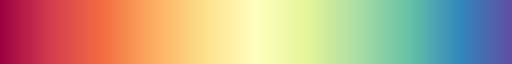

In [26]:
plt.cm.Spectral